# NFL Draft Round & Pick Model Prediction Using Combine Results
Every year, the NFL invites over 300 prospects to perform at the NFL Combine. The main purpose of the combine is for prospects to display their raw talents to teams before the NFL Draft. Prospects perform in events like the 40 Yard Dash, Bench Press, Vertical Jump, and many more. Teams then decide who they are going to draft based upon combine measurements, college performance. etc.

In this project, our goal is to create a model that can predict the round or pick each prospect will be taken at.

## Importing Our Data
We'll start by loading in several useful libraries and reading our .csv files into dataframes. Our draft dataframe contains the round and pick that each player was drafted at; our combine dataframe contains general information and combine results concerning each player.

In [28]:
# imports libraries we'll use throughout the project
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report,mean_absolute_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.model_selection import  GridSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor

# loads our .csv files into dataframes
draft_df = pd.read_csv('draft.csv')
combine_df = pd.read_csv('combine.csv')

## Cleaning Our Data
### Dropping Unneccesary Columns & Merging Data
Each of our dataframes have several columns that don't serve as any use to us. So, we'll drop these columns in order to focus on what we care about. 

Our data also includes a column called `playerID`, which we'll use as the point to combine our draft and combine dataframes so we can have all the information we need in one place.

In [29]:
# drops unnecessary columns from our draft dataframe
draft_df = draft_df.drop(['teamId', 'dob', 'playerProfileUrl', 'homeCountry', 'highSchool', 'hsCity',
                         'hsState', 'hsCountry', 'collegeId', 'nflId', 'combineId', 'nameFirst', 
                          'nameLast', 'draftTradeValue', 'homeCity', 'heightInches', 'weight',
                         'position'], axis = 1)

# drops unnecessary columns from our combine dataframe
combine_df = combine_df.drop(['combineId', 'nameFirst', 'nameLast', 'hsCountry', 'collegeId', 'nflId',
                             'hsState', 'hsCity', 'combinePosition', 'combineYear', 'dob', 'highSchool',
                             'homeCountry', 'ageAtDraft', 'playerProfileUrl', 'homeState', 'college',
                             'homeCity', 'nameFull', 'heightInches', 'weight'], axis = 1)

# merges our draft and combine dataframes
df = pd.merge(draft_df, combine_df, how = 'inner', on = 'playerId')
df2=df.copy()

In [30]:
df2['ageAtDraft'] = df2['ageAtDraft'].round(1)

### Small Tweaks
There are a few small changes that we're going to make before we start creating models. First, we're going to remove the data from the 2019 NFL Draft because it contains no information about the draft rounds. Then, we will make very minor changes to ceratin columns while editing information about the positions in the data we'll keep. We're also going to remove the rows that have a `Null` value in the `position` column.

In [66]:
# removes the 2019 NFL Draft
df = df[df['draft'] != 2019]

# modifies some columns of our new dataframe
df['ageAtDraft'] = df['ageAtDraft'].round(1)
df['round'] = df['round'].astype(int)

# sets our positions to be a little more broad
df['position'].replace('DE', 'DL', inplace = True)
df['position'].replace('DT', 'DL', inplace = True)
df['position'].replace('OT', 'OL', inplace = True)
df['position'].replace('OG', 'OL', inplace = True)
df['position'].replace('C', 'OL', inplace = True)
df['position'].replace('OLB', 'LB', inplace = True)
df['position'].replace('S', 'DB', inplace = True)
df['position'].replace('FB', 'RB', inplace = True)

# drops kickers, punters, long snappers and an empty position ('')
df = df[df['position'] != 'K']
df = df[df['position'] != 'P']
df = df[df['position'] != 'LS']
df2= df2[df2['position']!='']

# removes the row missing a value for position
df = df.dropna(subset = ['position'])


### Filling Null Values
In order to create models, we can't have any null values in our data. We can't remove all rows with null values because it would take too much out of our data set. Since every remaining column with a null value is a combine result, we'll fill the null values with 0.

The list below that we define as `combine_cols` is all the events that we'll use later when constructing our models. We've only included the measurements that are taken and the events that occur in the modern NFL combines.

In [31]:
combine_cols = ['combineHeight', 'combineWeight', 'combineHand', 'combineArm', 'combine40yd', 'combineVert',
               'combineBench', 'combineShuttle', 'combineBroad', 'draft']

for col in combine_cols:
    df[col].fillna(0, inplace = True)
    
for dtype in ['object', 'int', 'float']:
    for col in df2.select_dtypes(include = dtype).columns:
        if dtype == 'object':
            df2[col] = df2[col].fillna('')
        else:
            df2[col] = df2[col].fillna(0)

### Fixing Draft Rounds
The modern day draft only has 7 rounds, but has had more than that in the past. Because of this, the model would predict certain prospects to be drafted in a round that no longer exists. So we'll consider any prospect with a prediction past round 7 to be undrafted, which will be respresented by the digit "8".

In [32]:
for i in range(8, 13):
    df['round'].replace(i, 8, inplace = True)

## Exploring Our Data
During data exploration, we'll primarily be looking for anything we can use to our advantage when making models, but we'll also include any interesting trends or findings in our data.

Let's look a little deeper into the information that our positions can provide us; starting with which position is most commonly drafted in the first round.

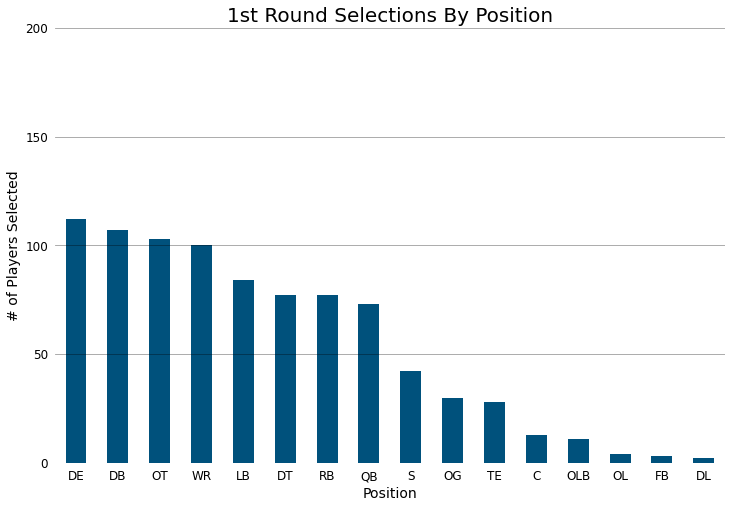

In [33]:
r1_pos = df[df['round'] == 1].groupby('position')['playerId'].count().sort_values(ascending = False)

fig, ax = plt.subplots(figsize = (12, 8))
ax = r1_pos.plot(kind = 'bar', color = '#00517c')

for loc in ['top', 'right', 'left', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.tick_params(left = False)
ax.tick_params(bottom = False)
plt.xticks(rotation = 0, fontsize = 12)
plt.yticks(ticks = [0, 50, 100, 150, 200], labels = [0, 50, 100, 150, 200], fontsize = 12)
plt.title('1st Round Selections By Position', fontsize = 20)
plt.xlabel('Position', fontsize = 14)
plt.ylabel('# of Players Selected', fontsize = 14)
ax.grid(axis = 'y', color = 'black', alpha = 0.4)
plt.show()

From our graph we can see that the defensive line is the most commonly selected position during the first round of the draft. This gives us a better understanding as to the strategy and needs of teams in the NFL. Something interesting we can take away from this is that QB is the 7th most drafted position in the first round, but it is the most commonly drafted position with the first pick.

In [7]:
df[df['pick'] == 1].groupby('position')['playerId'].count()

position
DL     5
OL     3
QB    17
RB     1
WR     1
Name: playerId, dtype: int64

Our data also includes information about the colleges that the prospects attended. Let's see if there's any relation to the college a prospect attends and if they get drafted.

In [8]:
df['college'].value_counts().head()

Florida State    157
Miami (FL)       145
Florida          143
Notre Dame       139
Nebraska         133
Name: college, dtype: int64

It appears that the college a prospect played for does somewhat encourage whether or not they get drafted. Intuitively, this makes sense as the general assumption would be that the higher skill level a prospect plays at, the more likely they are to play professionally.

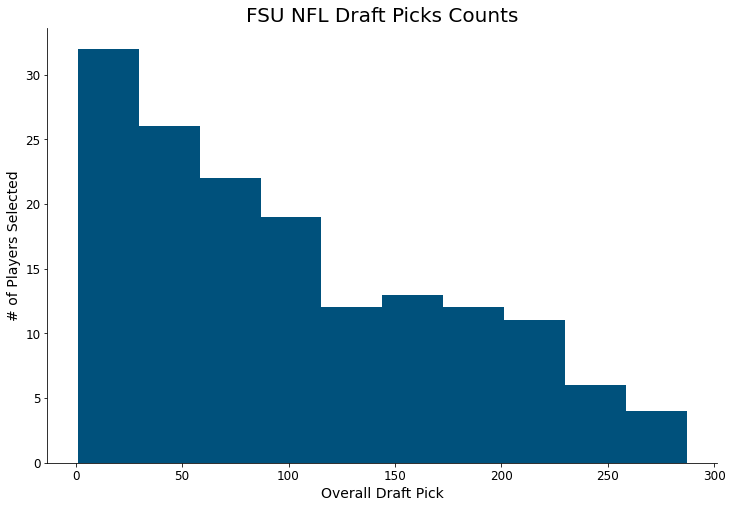

In [9]:
fig, ax = plt.subplots(figsize = (12, 8))
plt.hist(df[df['college']=='Florida State']['pick'], color = '#00517c')
plt.xlabel('Overall Draft Pick', fontsize = 14)
plt.ylabel('# of Players Selected', fontsize = 14)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title('FSU NFL Draft Picks Counts', fontsize = 20)
for loc in ['right', 'top']:
    ax.spines[loc].set_visible(False)
plt.show()

Florida State has an impressive number of selections overall with 157. A large majority of these selections took place in the first and second rounds, which supports the claim made previously about the correlation between skill level and whether or not a prospect plays professionally.

Now that we've manually explored some possible correlations in our data, let's use Python's built-in methods to look at correlation between our variables.

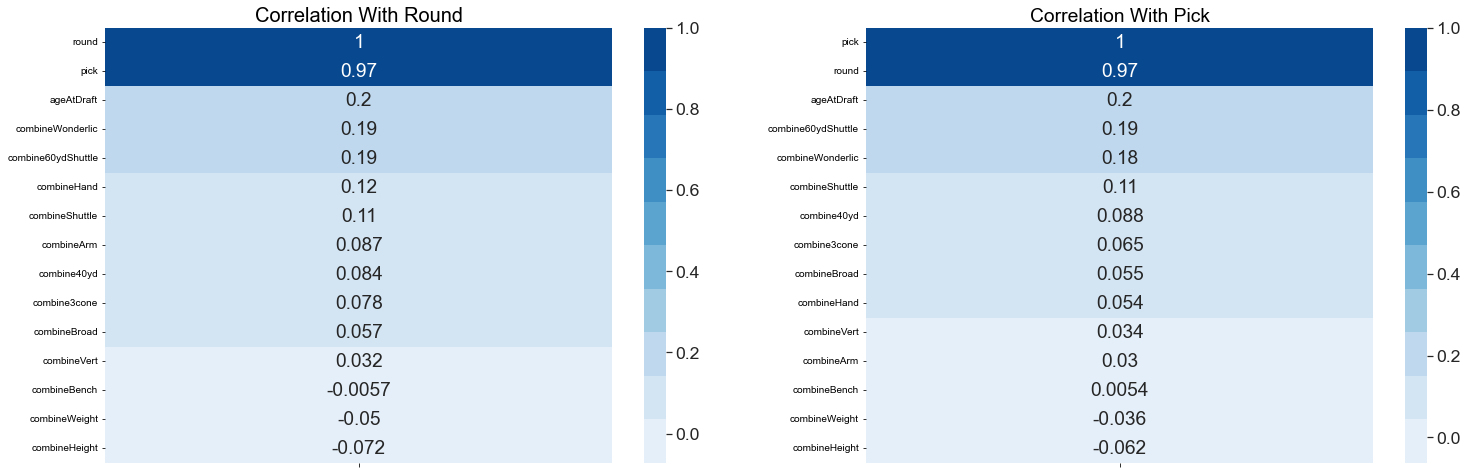

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (25, 8))
corr = df.drop(columns = ['playerId','draft']).corr()
sns.set(font_scale = 1.6)

x = corr[['round']]
sns.heatmap(x.sort_values(by = ['round'], ascending = False), cmap = sns.color_palette("Blues", 10), 
            annot = True, ax = axes[0])
axes[0].set_title('Correlation With Round', fontsize = 20)
axes[0].set_xticklabels([])

x = corr[['pick']]
sns.heatmap(x.sort_values(by=['pick'], ascending = False),cmap = sns.color_palette("Blues", 10), annot = True,
           ax = axes[1])
axes[1].set_title('Correlation With Pick')
axes[1].set_xticklabels([])
plt.show()

We can see that no variable has a particularly strong correlation with Round or Overall Pick. This can be for a number of reasons; let's revisit this after constructing and analyzing our model.

## Model Construction
For our model, we're going to use a Decision Tree Regressor to attempt to predict the pick a prospect will be selected at. We'll start by splitting our data into training and testing sets and then plotting what our model predicts for each prospect against the overall pick that they were actually selected at.

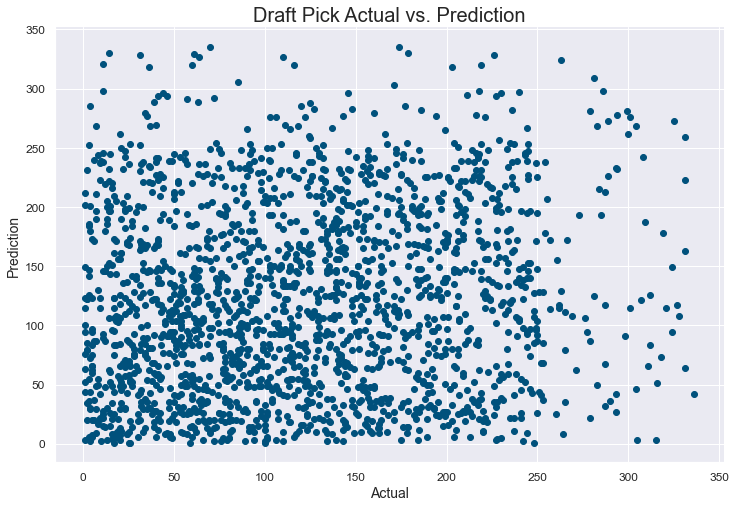

In [11]:
train_df, test_df = train_test_split(df, test_size = 0.3)

X_train = train_df[combine_cols]
X_test = test_df[combine_cols]
y_train = train_df['pick']
y_test = test_df['pick']


dt_reg = DecisionTreeRegressor(splitter = 'best', max_depth = 20)

dt_reg.fit(X_train, y_train)
y_preds = dt_reg.predict(X_test)

fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(x = y_test, y = y_preds, color = '#00517c')

for loc in ['top', 'right']:
    ax.spines[loc].set_visible(False)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Actual', fontsize = 14)
plt.ylabel('Prediction', fontsize = 14)
plt.title('Draft Pick Actual vs. Prediction', fontsize = 20)
plt.show()

As the plot shows us, our model waa way off on some predictions and spot on for others. This is most likely because of the role that technical ability plays during the draft process. In other words, teams don't always just look for the prospect with the best raw talent, but rather ones that possess technical abilities as well. The NFL Combine does have technical drills in which the measure a prospect's football abilities, but those results were not included in our data. If our data did have access to this kind of information, it would most likely be a lot more accurate in terms of predicting where a prospect will be selected.

In [12]:
df.to_csv('nfl_cleaned_data.csv')

# Models for Round Predictions


We started off by splitting our data into train and test dataframes. We used quarterbacks to look at the predictions of each model. First model was K Nearest Neighbors Regressor with 3 nearest neighbors.

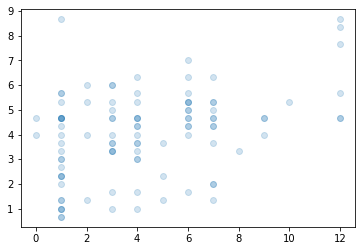

In [5]:
train_df, test_df = train_test_split(df2.loc[df2['position']=='QB'], train_size=0.7)
X_cols=[
        'combine40yd', 'combineVert', 'combineBench',
       'combineShuttle', 'combineBroad', 'combine3cone']

y_col=['round']

X_train = train_df[X_cols]
y_train = train_df[y_col]

X_test=test_df[X_cols]
y_test= test_df[y_col]

neigh = KNeighborsRegressor(n_neighbors=3)
neigh.fit(X_train,y_train)
y_pred_nn = neigh.predict(X_test)
plt.scatter(y_test,y_pred_nn,alpha=0.2)

After K Nearest Neighbors Regressor didn't show much linearity we tried fitting a decision tree regressor. We also did hyper paremeter tunning to find optimal paremeters. 

0.011352531193526149 {'max_depth': 2, 'min_samples_leaf': 7, 'min_samples_split': 40}


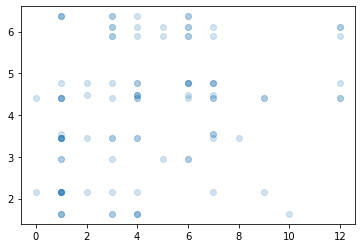

In [6]:
dt_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=30,min_samples_leaf=19)
dt_reg.fit(X_train,y_train)
dt_reg_preds = dt_reg.predict(X_test)
parameters = {'max_depth':[2,5,7], 
              'min_samples_split':[10,40,60],
              'min_samples_leaf':[7,8,10,12]}
grid = GridSearchCV(dt_reg, parameters)
grid.fit(X_train,y_train)
print(grid.best_score_,grid.best_params_)
plt.scatter(y_test,dt_reg_preds,alpha=0.2)

We realized that the output score from GSearchCV doesn't tell us much about our predictions so we decided to focus on the scatter plots and how well our predictions fit the actual values. The following model is a random forest regressor.

C:\Users\matil\AppData\Local\Temp\ipykernel_11504\3283534862.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_reg.fit(X_train,y_train)


0.06401618179885116
2.373048435879978


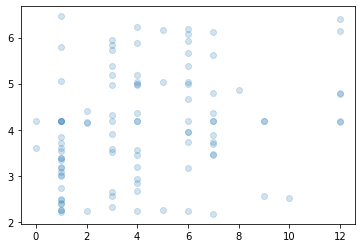

In [8]:
RF_reg=RandomForestRegressor(n_estimators=200, max_depth=20,min_samples_leaf=7, min_samples_split=19)
RF_reg.fit(X_train,y_train)
y_pred=RF_reg.predict(X_test)
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
plt.scatter(y_test,y_pred,alpha=0.2)

In [9]:
n_estimators = [50,100,150]
max_depth = [10,25,50]
min_samples_split = [15,20,25]
min_samples_leaf = [1,2,3,4,5,10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF_reg, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
print(bestF.best_score_,bestF.best_params_)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\matil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.04397892286280225 {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 25, 'n_estimators': 100}


The next model is gradient boosting regressor with n_estimators=200 and followed by hyperparemeter tunning.

C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.011233395306850746
2.4404526060977076


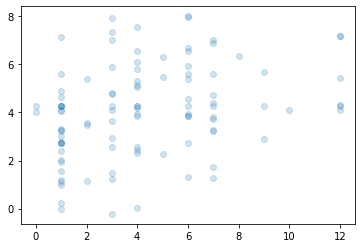

In [10]:
grd_reg=GradientBoostingRegressor(n_estimators=200, max_depth=20,min_samples_leaf=7, min_samples_split=19)
grd_reg.fit(X_train,y_train)
y_pred=grd_reg.predict(X_test)
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
plt.scatter(y_test,y_pred,alpha=0.2)

In [11]:
parameters = {'n_estimators':[20],
    'max_depth':[50,100,150], 
              'min_samples_split':[2,4,6,10],
              'min_samples_leaf':[2,4,8,10]}
grid = GridSearchCV(grd_reg,parameters,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_score_,grid.best_params_)

-0.007610373535201598 {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 6, 'n_estimators': 20}


C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Since regressors were not successful, we tried fitting all of those models as classifiers. Firts up is KNN with n_neighbors=7. 

2.27831715210356


C:\Users\matil\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


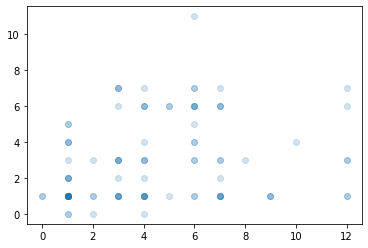

In [12]:
neigh_clf = KNeighborsClassifier(n_neighbors=7)
neigh_clf.fit(X_train,y_train)
y_pred_nn_reg = neigh_clf.predict(X_test)
#print(classification_report(y_test, y_pred_nn))
#plt.scatter(y, y_pred_nn)
print(mean_absolute_error(y_test, y_pred_nn))
plt.scatter(y_test,y_pred_nn_reg,alpha=0.2)

KNN didn't do a great job so we are fitting a decision tree classifier next. 

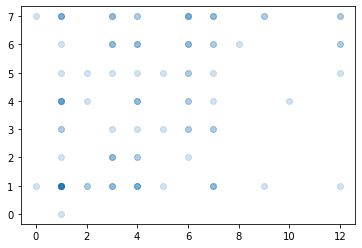

In [13]:
dt_clf = DecisionTreeClassifier(max_depth=30, min_samples_split=15,min_samples_leaf=6)
dt_clf.fit(X_train,y_train)
preds = dt_clf.predict(X_test)
parameters = {'max_depth':[2,5,7,10,50], 
              'min_samples_split':[2,5,7,10,30],
              'min_samples_leaf':[5,7,10,15,25]}
plt.scatter(y_test,preds,alpha=0.2)

In [14]:
grid = GridSearchCV(dt_clf, parameters)
grid.fit(X_train,y_train)
print(grid.best_score_,grid.best_params_)

C:\Users\matil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


0.23617021276595745 {'max_depth': 7, 'min_samples_leaf': 10, 'min_samples_split': 30}


Predictions for the first round looked good but we need more accuracy so we will continue down our list and fit a random forest classifier.

C:\Users\matil\AppData\Local\Temp\ipykernel_11504\2914773734.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train,y_train)


-0.5110250179268583
2.6699029126213594


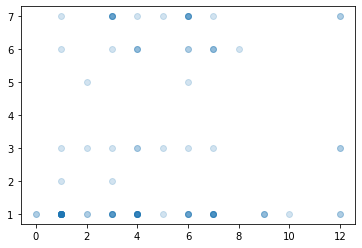

In [15]:
RF_clf=RandomForestClassifier(n_estimators=150,max_depth=150,min_samples_split=30,min_samples_leaf=6)
RF_clf.fit(X_train,y_train)
y_pred=RF_clf.predict(X_test)

print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
plt.scatter(y_test,y_pred,alpha=0.2)

In [16]:
n_estimators = [50,100,150]
max_depth = [100,150,200]
min_samples_split = [15,20,25,40]
min_samples_leaf = [1,2,3,4,5,10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(RF_clf, hyperF, cv = 3, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, y_train)
print(bestF.best_score_,bestF.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\matil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\matil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.22784810126582278 {'max_depth': 100, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 100}


Lastly, we fit gradient boosting classifier and run grid search cv to find the best parameters. We used the best paremeters as a good starting point for paremeter values. Once we plotted the scatter plot of predicted and actual values we adjusted some of the values based on the scatter plot.

C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-0.29355230658911635
2.650485436893204


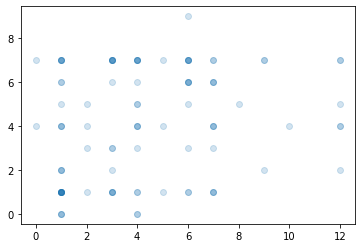

In [17]:
grd_clf=GradientBoostingClassifier(n_estimators=100,max_depth=19,min_samples_split=7,min_samples_leaf=10)
grd_clf.fit(X_train,y_train)
y_pred=grd_clf.predict(X_test)
print(r2_score(y_test,y_pred))
print(mean_absolute_error(y_test,y_pred))
plt.scatter(y_test,y_pred,alpha=0.2)

In [18]:
parameters = {'n_estimators':[50,100,150],
    'max_depth':[25,30,40,50], 
              'min_samples_split':[2,4,6,10],
              'min_samples_leaf':[2,4,8,10]}
grid = GridSearchCV(grd_clf,parameters,n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_score_,grid.best_params_)

C:\Users\matil\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


KeyboardInterrupt: 

Since non of the predictions were outstanding we decided to make an ensembled model that will take the average predictions for the regressors and mode predictions for classifiers.

2.466019417475728
-0.2617520516293521


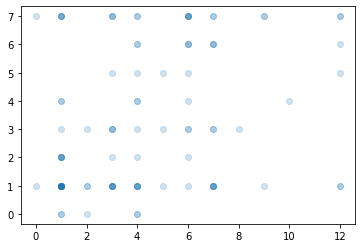

In [19]:
def ensembled_model(model1, model2, model3,model4, X):
    y1_pred = model1.predict(X)
    y2_pred = model2.predict(X)
    y3_pred = model3.predict(X)
    y4_pred = model4.predict(X)
    
    return mode([y1_pred, y2_pred, y3_pred,y4_pred]).mode[0]

y_pred_ens_clf= ensembled_model(neigh_clf,dt_clf,grd_clf,RF_reg,X_test)
print(mean_absolute_error(y_test,y_pred_ens_clf))
print(r2_score(y_test,y_pred_ens_clf))
plt.scatter(y_test,y_pred_ens_clf,alpha=0.2)

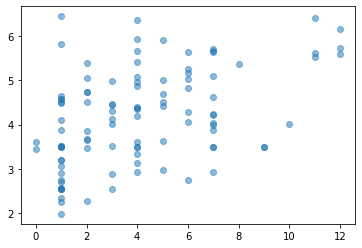

In [63]:
def ensembled_model_reg(model1, model2, model3,model4, X):
    y1_pred = model1.predict(X)
    y2_pred = model2.predict(X)
    y3_pred = model3.predict(X)
    y4_pred = model4.predict(X)
    avg_predictions=[]
    for row in range(len(y1_pred)):
        avg_pred=sum(y1_pred[[row]],y2_pred[[row]])
        avg_pred_1=sum(y4_pred[[row]],y3_pred[[row]])
        avg_preds=sum(avg_pred,avg_pred_1)
        avg_predictions.append(avg_preds/4)
    return avg_predictions
    
y_pred_reg=ensembled_model_reg(neigh,dt_reg,grd_reg,RF_reg,X_test)
plt.scatter(y_test,y_pred_reg,alpha=0.5)

After fitting all models into our ensembled model, we formed a for loop to do it for every position in our dataset.

C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_11504\2839408035.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train,y_train)
C:\Users\matil\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\matil\AppData\Local\Temp\ipykernel_11504\2839408035.py:28: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel()

C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_11504\2839408035.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train,y_train)
C:\Users\matil\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matil\anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\matil\AppData\Local\Temp\ipykernel_11504\2839408035.py:24: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_clf.fit(X_train,y_train)
C:\Users\matil\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example 

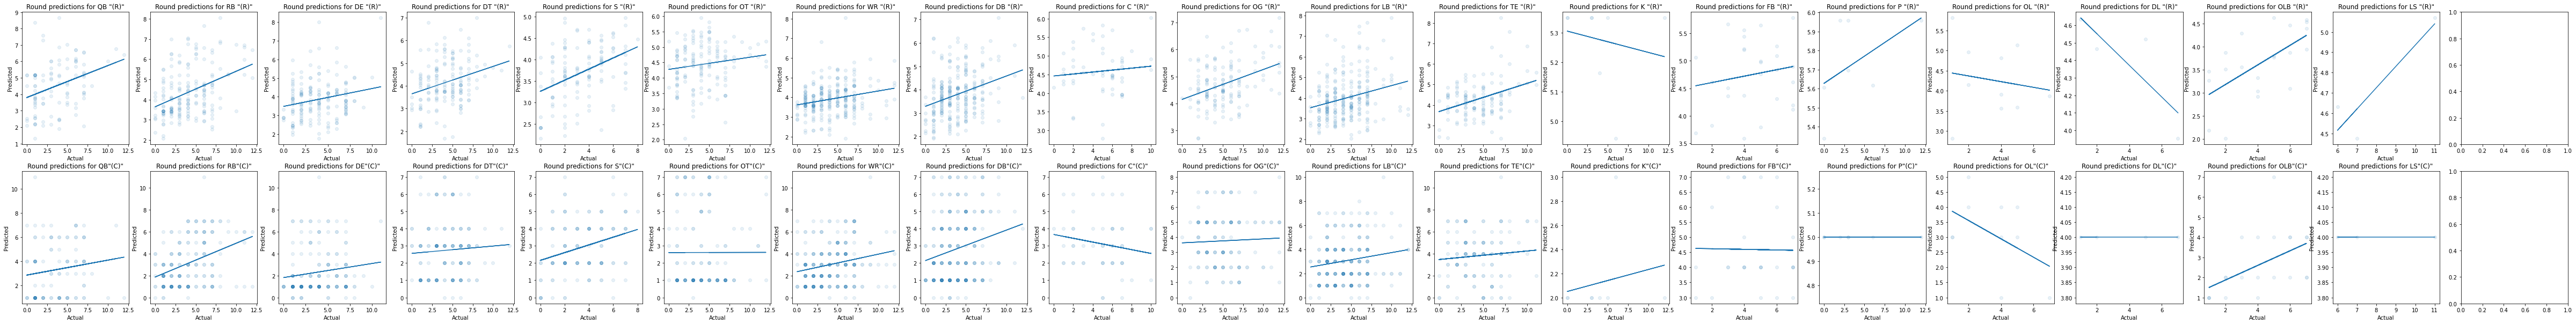

In [67]:
col=0
X_cols=['combine40yd', 'combineVert', 'combineBench',
       'combineShuttle', 'combineBroad', 'combine3cone']
y_col=['round']
fig, axs = plt.subplots(2,20,figsize=(85,10))
for pos in df2['position'].unique():
    df_pos=df2.loc[df2['position'] == pos]
    
    train_df, test_df = train_test_split(df_pos, test_size=0.3)
    
    X_train = train_df[X_cols]
    y_train = train_df[y_col]

    X_test= test_df[X_cols]
    y_test= test_df[y_col]
    
    neigh_reg = KNeighborsRegressor(n_neighbors=4)
    neigh_reg.fit(X_train,y_train)    
    dt_reg = DecisionTreeRegressor(max_depth=10, min_samples_split=30,min_samples_leaf=19)
    dt_reg.fit(X_train,y_train)    
    grd_reg=GradientBoostingRegressor(n_estimators=200, max_depth=20,min_samples_leaf=7, min_samples_split=19)
    grd_reg.fit(X_train,y_train)    
    RF_clf=RandomForestRegressor(n_estimators=150,max_depth=150,min_samples_split=30,min_samples_leaf=6)
    RF_clf.fit(X_train,y_train)
    neigh_clf = KNeighborsClassifier(n_neighbors=4)
    neigh_clf.fit(X_train,y_train)
    RF_clf=RandomForestClassifier(n_estimators=150,max_depth=150,min_samples_split=30,min_samples_leaf=6)
    RF_clf.fit(X_train,y_train)
    grd_clf=GradientBoostingClassifier(n_estimators=100,max_depth=19,min_samples_split=7,min_samples_leaf=10)
    grd_clf.fit(X_train,y_train)
    dt_clf = DecisionTreeClassifier(max_depth=30, min_samples_split=15,min_samples_leaf=6)
    dt_clf.fit(X_train,y_train)   
    avg_preds = ensembled_model_reg(neigh_reg,dt_reg,grd_reg,RF_reg,X_test)
    y_pred_ens_clf= ensembled_model(neigh_clf,dt_clf,grd_clf,RF_clf,X_test)    
    y_test=y_test.values.flatten()
    a, b = np.polyfit(y_test,avg_preds, 1)
    axs[0,col].scatter(y_test,avg_preds,alpha=0.1)
    axs[0,col].plot(y_test, a*y_test+b)
    
    axs[0,col].title.set_text(f'Round predictions for {pos} "(R)"')
    axs[0,col].set_xlabel('Actual')
    axs[0,col].set_ylabel('Predicted')
    a, b = np.polyfit(y_test,y_pred_ens_clf, 1)
    axs[1,col].scatter(y_test,y_pred_ens_clf,alpha=0.1)
    axs[1,col].plot(y_test, a*y_test+b)
    
    axs[1,col].title.set_text(f'Round predictions for {pos}"(C)"')
    axs[1,col].set_xlabel('Actual')
    axs[1,col].set_ylabel('Predicted')
    col+=1
          

# Conclusions

After running all of our model we conclude that Comine results are best used in conjunction with other information about a prospect. A model that has access to measurements of technical skill would most likely perform much better. There is that human part of scouting a player that cannot be measured and it plays a big role in the Draft. 

